In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import re

from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

import tensorflow as tf

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import warnings   


warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_validation=pd.read_csv('E:/github/disaster response messages/disaster_response_messages_validation.csv')
df_training=pd.read_csv('E:/github/disaster response messages/disaster_response_messages_training.csv')
df_test=pd.read_csv('E:/github/disaster response messages/disaster_response_messages_test.csv')

In [3]:
df_training.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [4]:
df_training.tail()

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
21041,30261,train,The training demonstrated how to enhance micro...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21042,30262,train,A suitable candidate has been selected and OCH...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21043,30263,train,"Proshika, operating in Cox's Bazar municipalit...",NaN,news,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21044,30264,train,"Some 2,000 women protesting against the conduc...",NaN,news,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21045,30265,train,A radical shift in thinking came about as a re...,NaN,news,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      21046 non-null  int64 
 1   split                   21046 non-null  object
 2   message                 21046 non-null  object
 3   original                8191 non-null   object
 4   genre                   21046 non-null  object
 5   related                 21046 non-null  int64 
 6   PII                     21046 non-null  int64 
 7   request                 21046 non-null  int64 
 8   offer                   21046 non-null  int64 
 9   aid_related             21046 non-null  int64 
 10  medical_help            21046 non-null  int64 
 11  medical_products        21046 non-null  int64 
 12  search_and_rescue       21046 non-null  int64 
 13  security                21046 non-null  int64 
 14  military                21046 non-null  int64 
 15  ch

In [6]:
df_training.describe()

,id,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,21046.000000,21046.000000,21046.0,21046.000000,21046.0,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,...,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000,21046.000000
mean,15207.883873,0.766464,0.0,0.169153,0.0,0.412667,0.078590,0.050889,0.029459,0.019101,...,0.012259,0.046945,0.278675,0.080633,0.093747,0.011356,0.094032,0.020194,0.054072,0.190488
std,8828.189299,0.441556,0.0,0.374896,0.0,0.492326,0.269104,0.219775,0.169094,0.136883,...,0.110042,0.211526,0.448358,0.272277,0.291483,0.105961,0.291880,0.140666,0.226165,0.392695
min,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7430.250000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15618.500000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22910.750000,1.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.000000,2.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_training.shape

(21046, 42)

In [8]:
df_training.duplicated().sum()

19

In [9]:
df_training.isnull().sum()

id                            0
split                         0
message                       0
original                  12855
genre                         0
related                       0
PII                           0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
child_alone                   0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops   

In [10]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [11]:
cleantext=[]
for item in tqdm(df_training['message']):
    words=tweet_to_words(str(item))
    cleantext+=[words]
df_training['cleanmessage']=cleantext
df_training

100%|████████████████████████████████████████████████████████████████████████████| 21046/21046 [04:31<00:00, 77.45it/s]


,id,split,message,original,genre,related,PII,request,offer,aid_related,...,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,cleanmessage
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[weather, updat, cold, front, cuba, could, pas..."
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,[hurrican]
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[say, west, side, haiti, rest, countri, today,..."
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[inform, nation, palac]"
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,"[storm, sacr, heart, jesu]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21041,30261,train,The training demonstrated how to enhance micro...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[train, demonstr, enhanc, micronutri, protein,..."
21042,30262,train,A suitable candidate has been selected and OCH...,NaN,news,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[suitabl, candid, select, ocha, jakarta, curre..."
21043,30263,train,"Proshika, operating in Cox's Bazar municipalit...",NaN,news,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[proshika, oper, cox, bazar, municip, 5, union..."
21044,30264,train,"Some 2,000 women protesting against the conduc...",NaN,news,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[2, 000, women, protest, conduct, elect, tearg..."


In [12]:
# Loading required features
df_training = df_training[['original', 'message', 'cleanmessage', 'genre', 'related']]
df_training.head(10)

,original,message,cleanmessage,genre,related
0,Un front froid se retrouve sur Cuba ce matin. ...,Weather update - a cold front from Cuba that c...,"[weather, updat, cold, front, cuba, could, pas...",direct,1
1,Cyclone nan fini osinon li pa fini,Is the Hurricane over or is it not over,[hurrican],direct,1
2,facade ouest d Haiti et le reste du pays aujou...,"says: west side of Haiti, rest of the country ...","[say, west, side, haiti, rest, countri, today,...",direct,1
3,Informtion au nivaux palais nationl,Information about the National Palace-,"[inform, nation, palac]",direct,0
4,Cyclone Coeur sacr de jesus,Storm at sacred heart of jesus,"[storm, sacr, heart, jesu]",direct,1
5,Tanpri nou bezwen tant avek dlo nou zon silo m...,"Please, we need tents and water. We are in Sil...","[pleas, need, tent, water, silo, thank]",direct,1
6,Mwen ta renmen jouin messag yo. Merci,"I would like to receive the messages, thank you","[would, like, receiv, messag, thank]",direct,0
7,Bon repo pa gen anyen menm grangou swaf,"There's nothing to eat and water, we starving ...","[noth, eat, water, starv, thirsti]",direct,1
8,M nan pv mvle plis enfomasyon sou 4636,I am in Petionville. I need more information r...,"[petionvil, need, inform, regard, 4636]",direct,0
9,Mwen thomassin 32 nan pyron mwen ta renmen jwe...,"I am in Thomassin number 32, in the area named...","[thomassin, number, 32, area, name, pyron, wou...",direct,1


In [13]:
Related = df_training[df_training['related'] == 1].shape[0]
Not_Related = df_training[df_training['related'] == 0].shape[0]
Not_Relevan = df_training[df_training['related'] == 2].shape[0]

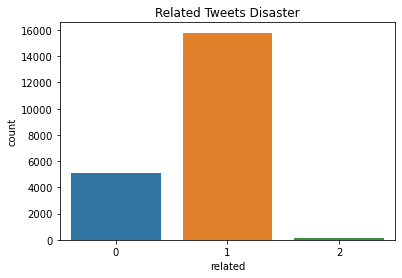

In [14]:
#The claims were suitable for an accelerated approval
sns.countplot(x="related", data=df_training)
plt.title('Related Tweets Disaster')
plt.show()

In [15]:
Direct = df_training[df_training['genre'] == 0].shape[0]
News = df_training[df_training['genre'] == 1].shape[0]
Social = df_training[df_training['genre'] == 2].shape[0]

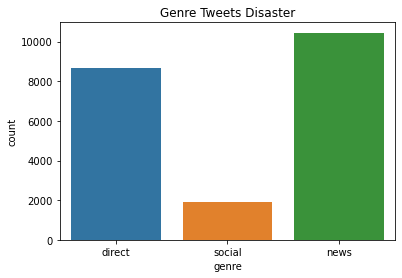

In [16]:
sns.countplot(x="genre", data=df_training)
plt.title('Genre Tweets Disaster')
plt.show()

Lower casing

In [17]:
df_training['message'] = [entry.lower() for entry in df_training['message']]
df_training['message'].head(10)

0    weather update - a cold front from cuba that c...
1              is the hurricane over or is it not over
2    says: west side of haiti, rest of the country ...
3               information about the national palace-
4                       storm at sacred heart of jesus
5    please, we need tents and water. we are in sil...
6      i would like to receive the messages, thank you
7    there's nothing to eat and water, we starving ...
8    i am in petionville. i need more information r...
9    i am in thomassin number 32, in the area named...
Name: message, dtype: object

In [18]:
df_training['message'] = [word_tokenize(entry) for entry in df_training['message']]

In [19]:
df_training['message'].head(10)

0    [weather, update, -, a, cold, front, from, cub...
1    [is, the, hurricane, over, or, is, it, not, over]
2    [says, :, west, side, of, haiti, ,, rest, of, ...
3         [information, about, the, national, palace-]
4                [storm, at, sacred, heart, of, jesus]
5    [please, ,, we, need, tents, and, water, ., we...
6    [i, would, like, to, receive, the, messages, ,...
7    [there, 's, nothing, to, eat, and, water, ,, w...
8    [i, am, in, petionville, ., i, need, more, inf...
9    [i, am, in, thomassin, number, 32, ,, in, the,...
Name: message, dtype: object

In [20]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['j'] = wn.ADJ
tag_map['v'] = wn.VERB
tag_map['v'] = wn.ADV

In [21]:
# Storing all the stopwords into variables
stop_words = set(stopwords.words("english"))
print(stop_words)

{'s', 'isn', "it's", 'few', 'for', 'them', "needn't", 'through', 'nor', 're', 'herself', 'o', "won't", 'being', 'your', 'hasn', 'all', 'its', 'i', 'who', 'whom', 'they', 've', 'which', 'theirs', 'in', 'can', 'she', 'why', 'any', 'this', 'y', "shouldn't", 'been', "haven't", 'wasn', 'where', 'no', 'each', 'wouldn', 'because', 'having', 'own', 'not', 'these', 'before', 'most', 'doing', 'has', 'at', "shan't", 'himself', 'me', 'when', 'will', 'on', 'hadn', "hasn't", "wouldn't", 'have', 'needn', 'same', 'between', 'am', 'until', 'we', 'only', 'should', 'couldn', 'didn', 'to', 'our', 'and', 'into', "she's", 'against', 'myself', 'or', 'shouldn', 'll', 'does', 'what', "mightn't", 'too', 'very', 'was', 'so', 'up', 'that', 'further', 'him', 'itself', 'there', 'during', "isn't", 'doesn', 'haven', 'their', 'weren', 'below', 'it', 'mightn', 'of', 'hers', 'both', 'is', 'the', 'aren', 'm', 'he', 'won', 'down', 'just', 'those', "hadn't", 't', "don't", "you've", 'again', 'ain', 'yourself', 'you', 'ours'

In [22]:
for index,entry in enumerate(df_training['message']):
    Final_words = []
    word_lemmstized = WordNetLemmatizer()
    for word,tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_final = word_lemmstized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_final)
    df_training.loc[index,'message_final'] = str(Final_words)

In [23]:
df_training.head(10)

,original,message,cleanmessage,genre,related,message_final
0,Un front froid se retrouve sur Cuba ce matin. ...,"[weather, update, -, a, cold, front, from, cub...","[weather, updat, cold, front, cuba, could, pas...",direct,1,"['weather', 'update', 'cold', 'front', 'cuba',..."
1,Cyclone nan fini osinon li pa fini,"[is, the, hurricane, over, or, is, it, not, over]",[hurrican],direct,1,['hurricane']
2,facade ouest d Haiti et le reste du pays aujou...,"[says, :, west, side, of, haiti, ,, rest, of, ...","[say, west, side, haiti, rest, countri, today,...",direct,1,"['say', 'west', 'side', 'haiti', 'rest', 'coun..."
3,Informtion au nivaux palais nationl,"[information, about, the, national, palace-]","[inform, nation, palac]",direct,0,"['information', 'national']"
4,Cyclone Coeur sacr de jesus,"[storm, at, sacred, heart, of, jesus]","[storm, sacr, heart, jesu]",direct,1,"['storm', 'sacred', 'heart', 'jesus']"
5,Tanpri nou bezwen tant avek dlo nou zon silo m...,"[please, ,, we, need, tents, and, water, ., we...","[pleas, need, tent, water, silo, thank]",direct,1,"['please', 'need', 'tent', 'water', 'silo', 't..."
6,Mwen ta renmen jouin messag yo. Merci,"[i, would, like, to, receive, the, messages, ,...","[would, like, receiv, messag, thank]",direct,0,"['would', 'like', 'receive', 'message', 'thank']"
7,Bon repo pa gen anyen menm grangou swaf,"[there, 's, nothing, to, eat, and, water, ,, w...","[noth, eat, water, starv, thirsti]",direct,1,"['nothing', 'eat', 'water', 'starving', 'thirs..."
8,M nan pv mvle plis enfomasyon sou 4636,"[i, am, in, petionville, ., i, need, more, inf...","[petionvil, need, inform, regard, 4636]",direct,0,"['petionville', 'need', 'information', 'regard..."
9,Mwen thomassin 32 nan pyron mwen ta renmen jwe...,"[i, am, in, thomassin, number, 32, ,, in, the,...","[thomassin, number, 32, area, name, pyron, wou...",direct,1,"['thomassin', 'number', 'area', 'named', 'pyro..."


WORDCLOUD

In [24]:
# splitting all the words from the data and assining those to Comment-words
comment_words = ' '
stopwords = set(STOPWORDS)

In [25]:
for val in df_training.message_final:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '

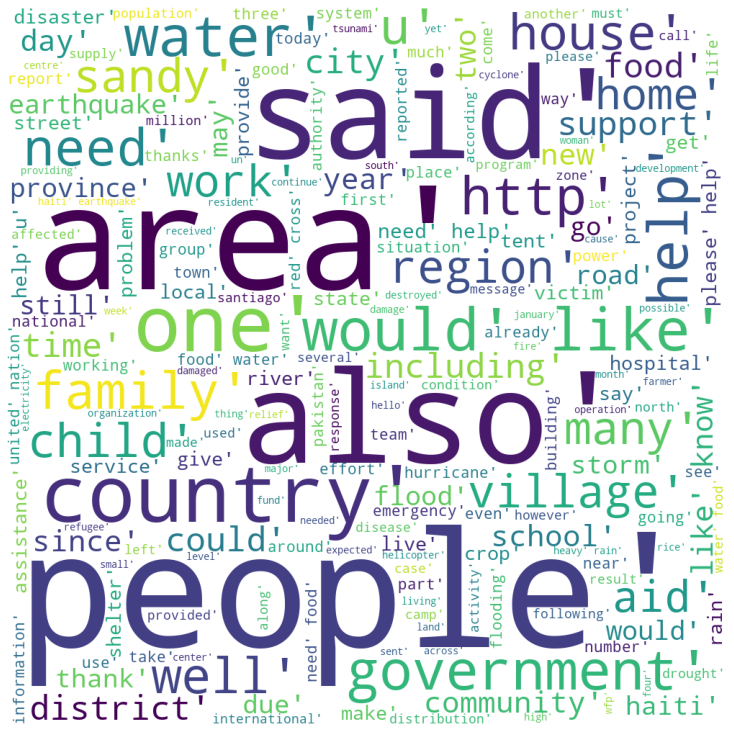

In [26]:
wordcloud = WordCloud(width = 1000, height =1000, background_color = 'white',
                      stopwords = stopwords,min_font_size = 10).generate(comment_words)


plt.figure(figsize = (10,10), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Naive Bayes

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection,naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [28]:
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df_training['message_final'],df_training['related'],test_size = 0.3)
encoder = LabelEncoder()
Train_Y = encoder.fit_transform(Train_Y)
Test_Y = encoder.fit_transform(Test_Y)

In [29]:
y = Train_Y.tolist()

In [30]:
Tfidf_vect = TfidfVectorizer(max_features = 5000)
Tfidf_vect.fit(df_training['message_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [31]:
data = Train_X_Tfidf.toarray()

In [32]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
naive = naive_bayes.MultinomialNB()
naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

In [34]:
predictions_NB = naive.predict(Test_X_Tfidf)

In [35]:
print("Naive Bayes Model Accuracy : ",accuracy_score(predictions_NB,Test_Y)*100)

Naive Bayes Model Accuracy :  80.51948051948052


RandomForest 

In [36]:
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df_training['message_final'],df_training['related'],test_size = 0.3)
encoder = LabelEncoder()
Train_Y = encoder.fit_transform(Train_Y)
Test_Y = encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features = 5000)
Tfidf_vect.fit(df_training['message_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [37]:
#loading random forest
from sklearn.ensemble import RandomForestClassifier

#Setting random forest 
RandomForest = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=9)

RandomForest.fit(Train_X_Tfidf,Train_Y)

#making predcitons with randome forest model
label_predict = RandomForest.predict(Test_X_Tfidf)

accuracy = accuracy_score( label_predict,Test_Y)
print(("Accuracy of RandomForest: ", accuracy*100))

('Accuracy of RandomForest: ', 79.96515679442508)


LogisticRegression 

In [38]:
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df_training['message_final'],df_training['related'],test_size = 0.3)
encoder = LabelEncoder()
Train_Y = encoder.fit_transform(Train_Y)
Test_Y = encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features = 5000)
Tfidf_vect.fit(df_training['message_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(Train_X_Tfidf,Train_Y)

label_predict = logreg.predict(Test_X_Tfidf)


accuracy = accuracy_score(label_predict,Test_Y)
print(("Accuracy of logreg: ", accuracy*100))

('Accuracy of logreg: ', 81.20050681026291)


LSTM

In [39]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
tf.keras.optimizers.Adam
%matplotlib inline

In [40]:
Train_X,Test_X,Train_Y,Test_Y = model_selection.train_test_split(df_training['message_final'],df_training['related'],test_size = 0.3)
encoder = LabelEncoder()
Train_Y = encoder.fit_transform(Train_Y)
Test_Y = encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features = 5000)
Tfidf_vect.fit(df_training['message_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Train_X)
sequences = tok.texts_to_sequences(Train_X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [41]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [42]:
model = RNN()
model.summary()
model.compile(optimizer= "adam", loss='mse', metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
FC1 (Dense)                  (None, 150, 256)          13056     
_________________________________________________________________
activation (Activation)      (None, 150, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 256)          0         
_________________________________________________________________
out_layer (Dense)            (None, 150, 1)            257       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 1)            0     

In [43]:
model.fit(sequences_matrix,Train_Y,batch_size=128,epochs=20,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/20
93/93 [==============================] - 43s 191ms/step - loss: 0.2234 - accuracy: 0.7294 - val_loss: 0.1901 - val_accuracy: 0.7587


In [44]:
test_sequences = tok.texts_to_sequences(Test_X)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [45]:
accr = model.evaluate(test_sequences_matrix,Test_Y)

198/198 [==============================] - 2s 7ms/step - loss: 0.1948 - accuracy: 0.7529


In [46]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.195
  Accuracy: 0.753


Conclusion : 
    
    The best Machine Learning is LogisticRegression with Accuracy 81.21634463097878% compares with Naive Bayes and RandomForest